In [ ]:
# edited
!pip install --upgrade click==8.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.8
    Uninstalling click-8.1.8:
      Successfully uninstalled click-8.1.8


In [ ]:
# Install Kaggle API
!pip install kaggle

# Upload kaggle.json for Kaggle API authentication
from google.colab import files
files.upload()  # Upload your kaggle.json file here

# Set up Kaggle configuration
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d Cornell-University/arxiv
!unzip arxiv.zip

# Install Dask with distributed module
!pip install "dask[distributed]"

# Suppress spacy logger output if using spacy later
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

# Import necessary libraries
import dask.bag as db
import json
import pandas as pd
from dask.distributed import Client

# Initialize the Dask client
client = Client()

# Load the dataset using Dask
docs = db.read_text('arxiv-metadata-oai-snapshot.json').map(json.loads)

# Example: Count the total number of documents
doc_count = docs.count().compute()
print(f"Total number of documents: {doc_count}")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.35G/1.36G [00:23<00:00, 55.6MB/s]
100% 1.36G/1.36G [00:23<00:00, 61.5MB/s]
Archive:  arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.3 MB/s eta 0:00:00


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33029
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34633'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35719'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:38565', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38565
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:45396
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:37589', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker co

Total number of documents: 2606260


In [ ]:
# Looking at one document:
docs.take(5)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

In [ ]:
# The dataset is very huge. Not sure if the whole set can be used. I start prototyping with a subset of the data so it's easyer to handel:
# This procedure was recommended in the ArXiv dataset itself

get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'id': x['id'],
                  'authors': x['authors'],
                  'title': x['title'],
                  'doi': x['doi'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract'],}
# filter for papers published on or after 2024-01-01
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2023)
           .map(trim).
           compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

INFO:distributed.core:Event loop was unresponsive in Scheduler for 8.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 6.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [ ]:
#save trimmed dataset for later use so we can skip the dataset trimming later:
docs_df.to_csv("trimmed_arxiv_docs.csv", index=False)

In [ ]:
#Let's have a look at the first 5 rows:
docs_df.head()

id                                            authors  \
0  0704.2253  William T. Reach, Michael S. Kelley, Mark V. S...   
1  0705.1329                                  Richard J. Mathar   
2  0706.0190                                         Hou Y. Yau   
3  0706.0725          Daniel Birmajer, Juan Gil, Michael Weiner   
4  0706.0859                                M. Boggi, P. Lochak   

                                               title  \
0  A survey of debris trails from short-period co...   
1  Third Order Newton's Method for Zernike Polyno...   
2  Quantum Properties and Gravitational Field of ...   
3  Factorization of quadratic polynomials in the ...   
4  Profinite complexes of curves, their automorph...   

                            doi                              category  \
0  10.1016/j.icarus.2007.03.031                            [astro-ph]   
1                          None                      [math.NA, cs.NA]   
2                          None                      [physics.gen-ph]   
3                          None  [math.AC, math.GM, math.NT, math.RA]   
4                          None                    [math.AG, math.NT]   

                                            abstract  
0    We observed 34 comets using the 24 micron ca...  
1    The Zernike radial polynomials are a system ...  
2    We find that a field with oscillations of ma...  
3    We establish necessary and sufficient condit...  
4    Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t...

In [ ]:
df = pd.read_csv("./trimmed_arxiv_docs.csv")

<ipython-input-7-00dad3b2a3e3>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./trimmed_arxiv_docs.csv")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480473 entries, 0 to 480472
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        480473 non-null  object
 1   authors   480473 non-null  object
 2   title     480473 non-null  object
 3   doi       95414 non-null   object
 4   category  480473 non-null  object
 5   abstract  480473 non-null  object
dtypes: object(6)
memory usage: 22.0+ MB


In [ ]:
df.shape

(480473, 6)

In [ ]:
#Addint word counts of each abstract could be a usefull feature
df['abstract_word_count'] = docs_df['abstract'].apply(lambda x: len(x.strip().split()))

In [ ]:
df['abstract'].describe(include='all')

count                                                480473
unique                                               480401
top         We construct the family of bilinear forms gG...
freq                                                      3
Name: abstract, dtype: object

In [ ]:
#There are duplicated abstracts, would be the best to get rid of these
df.drop_duplicates(['abstract',], inplace=True)
df['abstract'].describe(include='all')

count                                                480401
unique                                               480401
top         We observed 34 comets using the 24 micron ca...
freq                                                      1
Name: abstract, dtype: object

In [ ]:
# the dataframe contains still hugh amount of data. The process the data faster I reduce the df to 10000 rows
# The scope of the notebook is not to analyze all data
df = df.sample(10000, random_state=42)

In [ ]:
from tqdm import tqdm
# I discoverd that it's possible to download models for the specific purpose to preprocess scientific texts
# In the spacy docs I found a specific model for this : https://spacy.io/universe/project/scispacy
#Downloading en_core_sci_lg model to preprocess abstracts
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
docs_df.to_csv('/content/drive/MyDrive/trimmed_arxiv_docs.csv', index=False)  # Save to Google Drive


Mounted at /content/drive


In [ ]:
#!pip install --upgrade click==8.1.3
!pip install spacy
!pip install scispacy
#!pip install https://github.com/allenai/scispacy/releases/download/v0.5.0/en_core_sci_lg-0.5.0.tar.gz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 2.0 MB/s eta 0:00:00
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578645 sha256=8e532934073cdcda5371f66b99d681148e9a5cc1e4c796e5c6d49fcf13181f58
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib


In [ ]:
import spacy
import en_core_sci_lg

# Load the NLP model
nlp = en_core_sci_lg.load()

print("Model loaded successfully!")


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount if already mounted

import pandas as pd  # Re-import Pandas
docs_df = pd.read_csv('/content/drive/MyDrive/trimmed_arxiv_docs.csv')  # Load dataset


Mounted at /content/drive


<ipython-input-18-19475e7ef241>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  docs_df = pd.read_csv('/content/drive/MyDrive/trimmed_arxiv_docs.csv')  # Load dataset


In [ ]:
# Reinstall click to resolve import error


# Install additional NLP libraries and models
!pip install spacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz

# Import necessary NLP libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

# Load the large scientific model
nlp = en_core_sci_lg.load()

# Test loading of model
print("Model loaded successfully.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.2/531.2 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_sci_lg: filename=en_core_sci_lg-0.5.4-py3-none-any.whl size=531476535 sha256=245f2c18920659f56075cbf068270eacfce8ca6ba303b83f15b328ae5ddc26cb
  Stored in directory: /root/.cache/pip/wheels/04/77/e7/614feae28ed7056dd89b009b32c30573bd85fb7d1ea3c7c227
Successfully built en_core_sci_lg


INFO:distributed.core:Event loop was unresponsive in Nanny for 13.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 13.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 13.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
/usr/local/lib/python3.10/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


Model loaded successfully.


In [ ]:
#Import NLP librarys and the spacy package to preprocess the abstract text
import spacy
from spacy.lang.en.stop_words import STOP_WORDS #import commen list of stopword
import en_core_sci_lg  # import downlaoded model

In [ ]:
# Parser
parser = en_core_sci_lg.load()
parser.max_length = 7000000 #Limit the size of the parser

def spacy_tokenizer(sentence):
    ''' Function to preprocess text of scientific papers
        (e.g Removing Stopword and puntuations)'''
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ] # transform to lowercase and then split the scentence
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ] #remove stopsword an punctuation
    mytokens = " ".join([i for i in mytokens])
    return mytokens

INFO:distributed.core:Event loop was unresponsive in Nanny for 22.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 22.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 22.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause time

In [ ]:
import string

punctuations = string.punctuation #list of punctuation to remove from text
stopwords = list(STOP_WORDS)
stopwords[:10]

['’s',
 'about',
 'may',
 'again',
 'his',
 'down',
 'made',
 'also',
 'until',
 'elsewhere']

In [ ]:
tqdm.pandas()
df["processed_text"] = df["abstract"].progress_apply(spacy_tokenizer)

100%|██████████| 10000/10000 [11:13<00:00, 14.84it/s]


In [ ]:
# Import vectorizer and define vec function
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):

    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [ ]:
#vectorize each processed abstract
text = df['processed_text'].values
X = vectorize(text, 2 ** 12) #arbitrary max feature -_> Hyperpara. for optimisation (?)
X.shape

(10000, 4096)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42) #Keep 95% of the variance
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

INFO:distributed.core:Event loop was unresponsive in Nanny for 123.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 123.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 123.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


(10000, 2803)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn import metrics

In [ ]:


# find optimal k value
#r_seed = 24
#cluster_errors = []

#for i in range(1, 50):
    #n_clusters = i
    #pipe_pca_kmean = Pipeline([("cluster", KMeans(n_clusters=n_clusters, random_state=r_seed, verbose=0, n_jobs=1))]
    #)

    #pipe_pca_kmean.fit(X_reduced)
    #pipe_pca_kmean.predict(X_reduced)
    #cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)



In [ ]:
#plt.clf()
#plt.plot(cluster_errors, "o-")
#plt.xlabel("k_clusters")
#plt.ylabel("sum sq distances from mean")
#plt.show(

In [ ]:
k = 20 # optimal k found in elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['kmean_clusters'] = y_pred

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
from umap import UMAP

INFO:distributed.core:Event loop was unresponsive in Nanny for 3.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [ ]:
# UMAP Definition:
umap_embeddings = UMAP(n_neighbors=100, min_dist=0.3, n_components=2)

In [ ]:
X_umap = umap_embeddings.fit_transform(X_reduced)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.047s...
[t-SNE] Computed neighbors for 10000 samples in 39.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.317399
[t-SNE] KL divergence after 50 iterations with early exaggeration: 82.977928
[t-SNE] KL divergence after 1000 iterations: 2.520978


<ipython-input-36-c642d26ce12e>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)


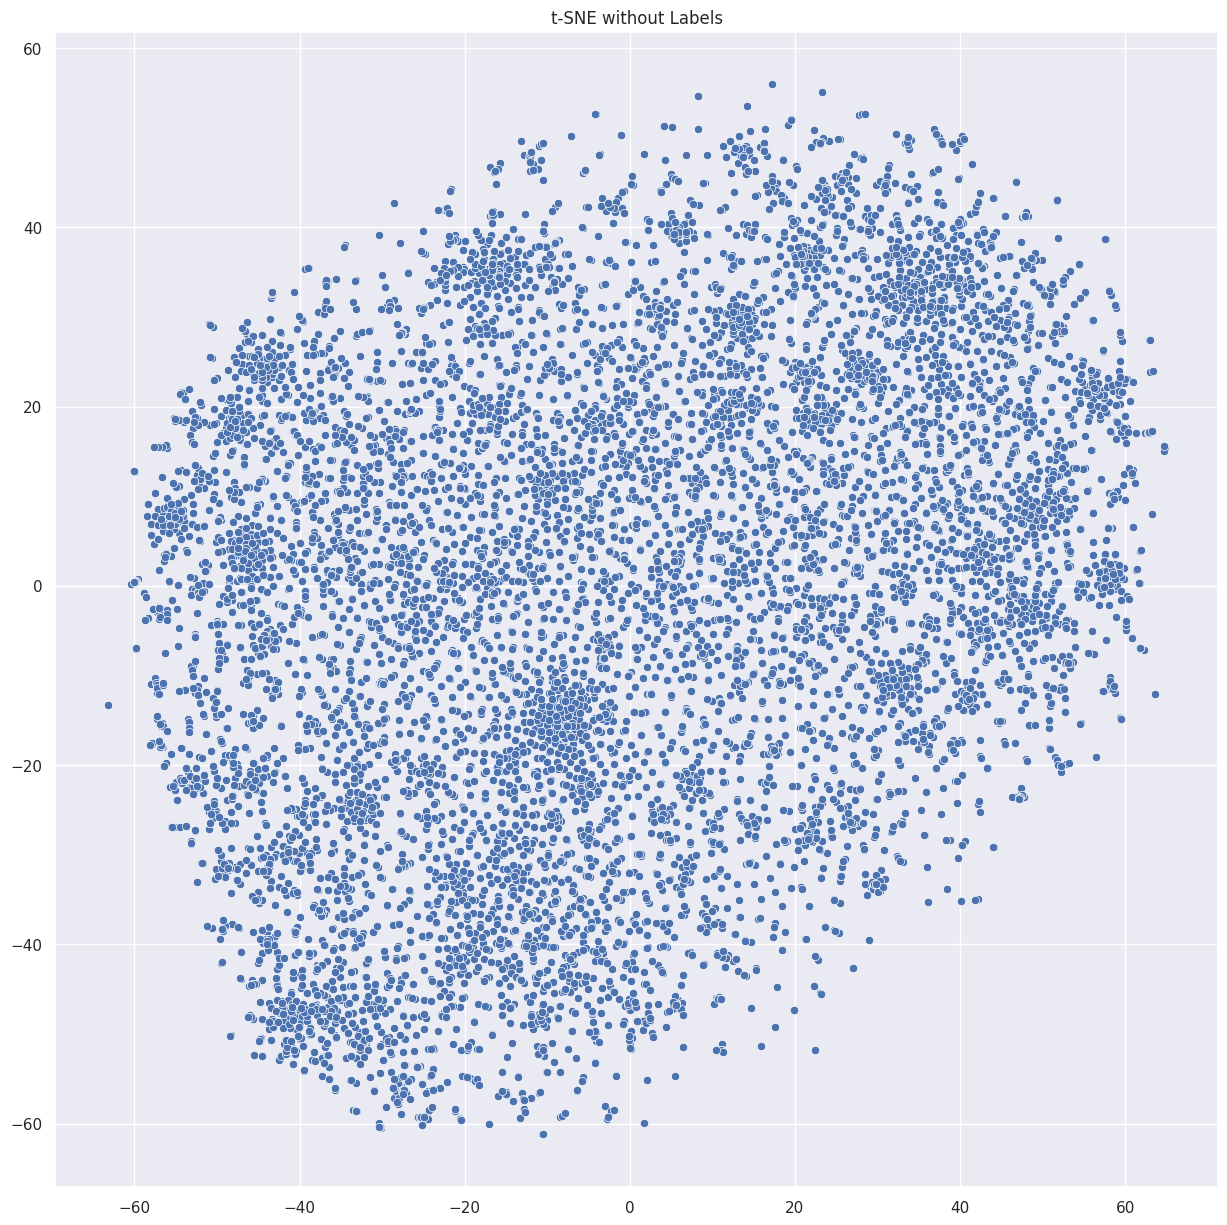

In [ ]:
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)
plt.title('t-SNE without Labels')
plt.savefig("t-sne_arxvid.png")
plt.show()

<ipython-input-37-b507ca684b7f>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], palette=palette)


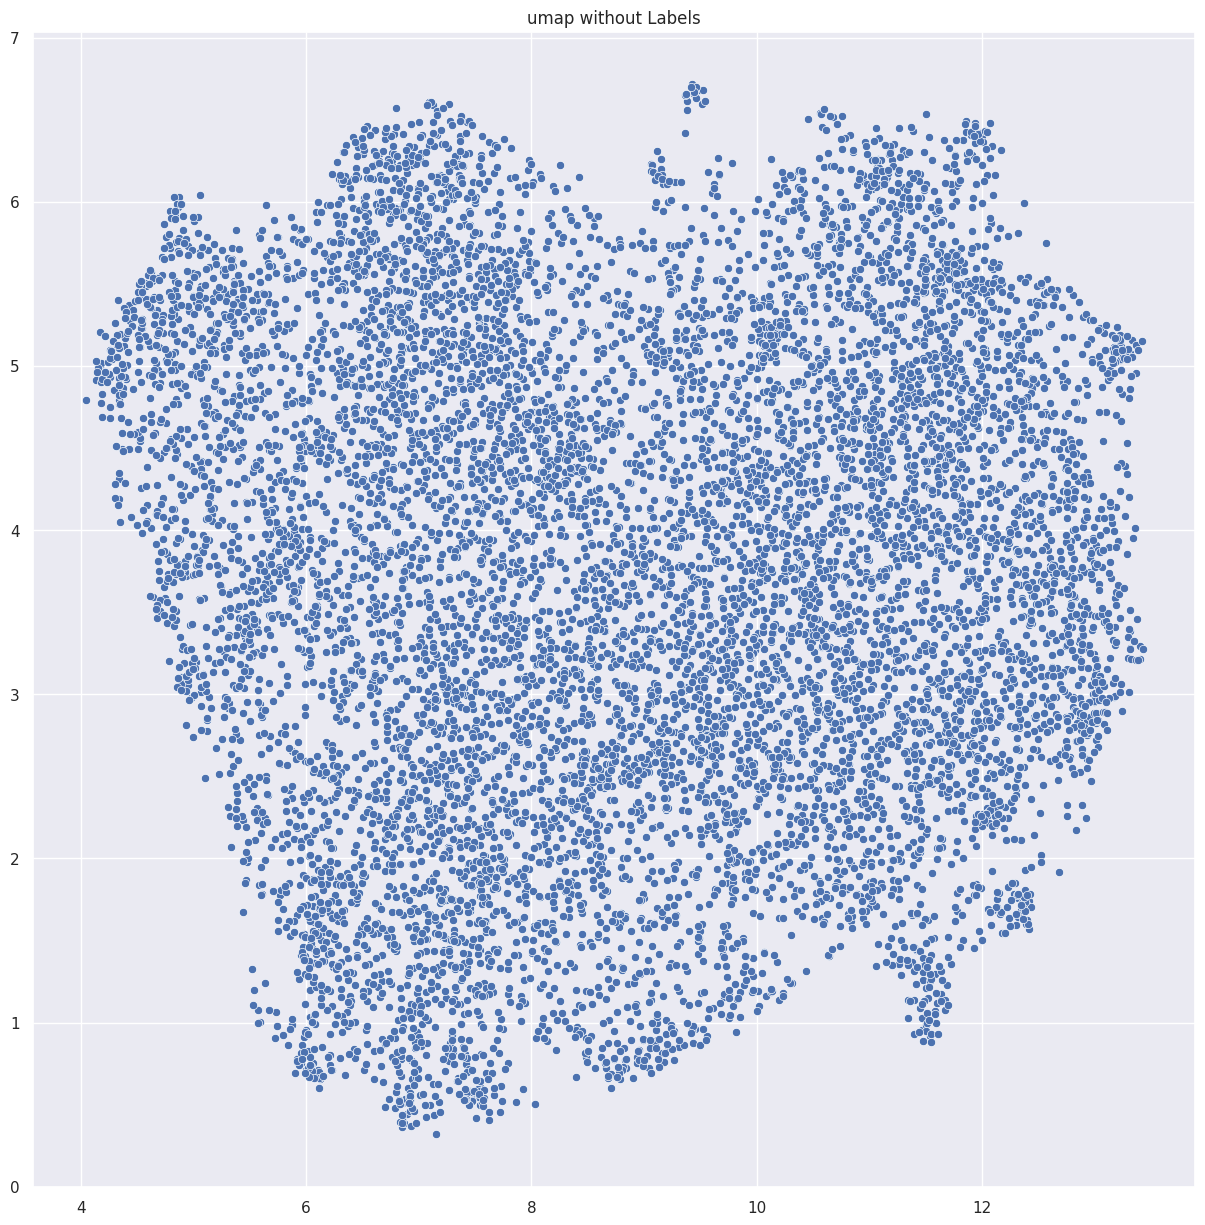

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], palette=palette)
plt.title('umap without Labels')
plt.savefig("umap_arxvid.png")
plt.show()

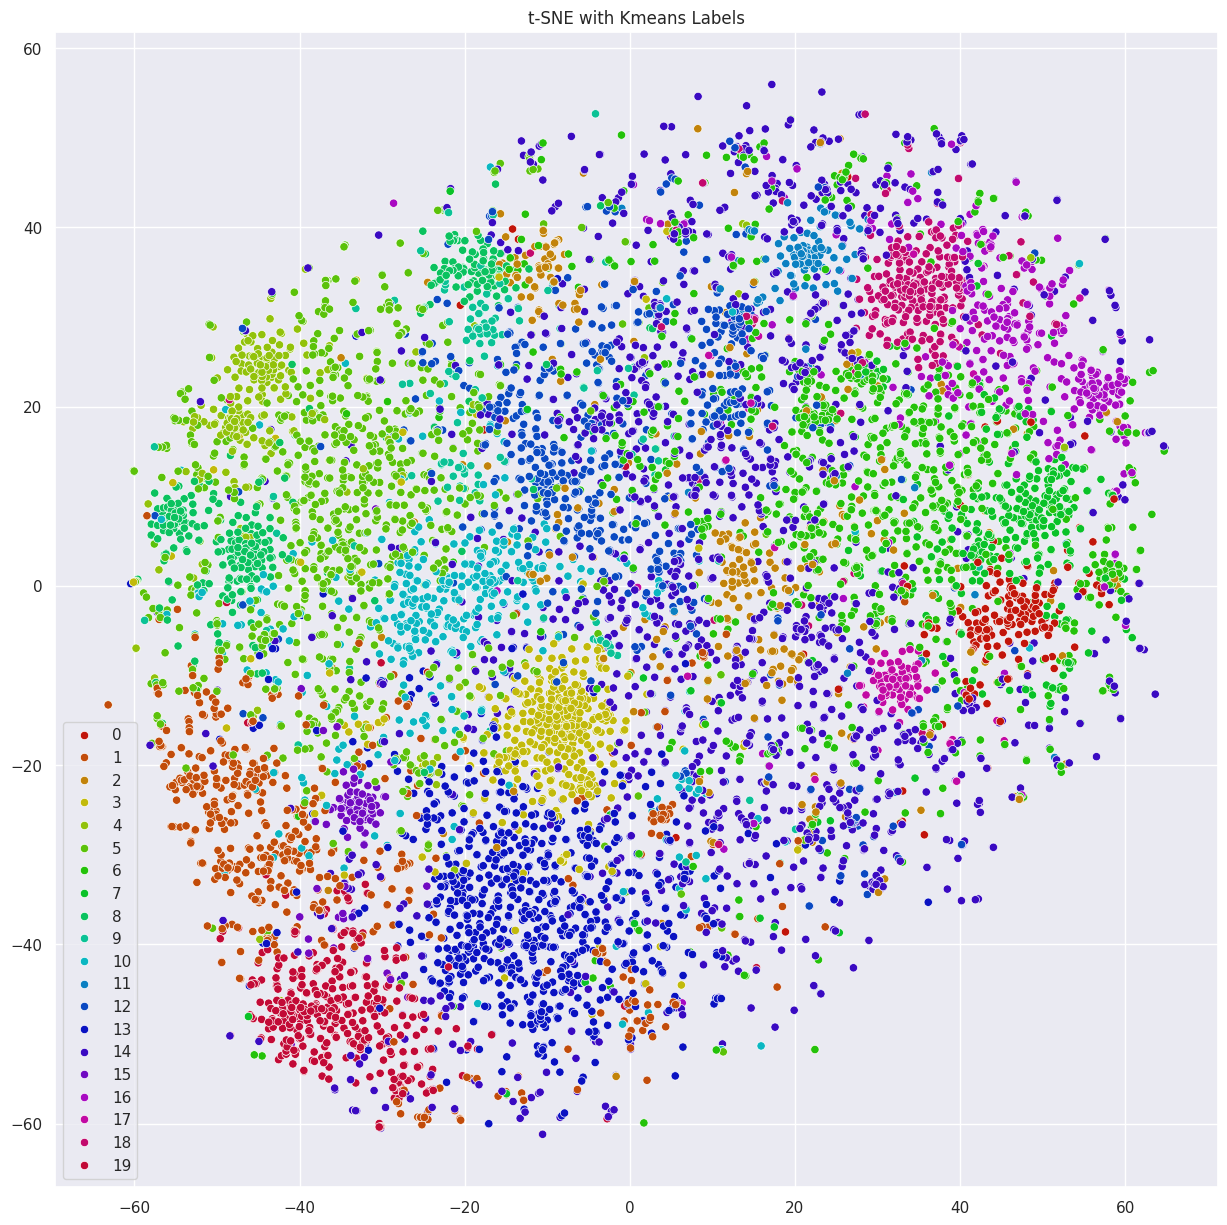

In [ ]:
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("cluster_tsne.png")
plt.show()

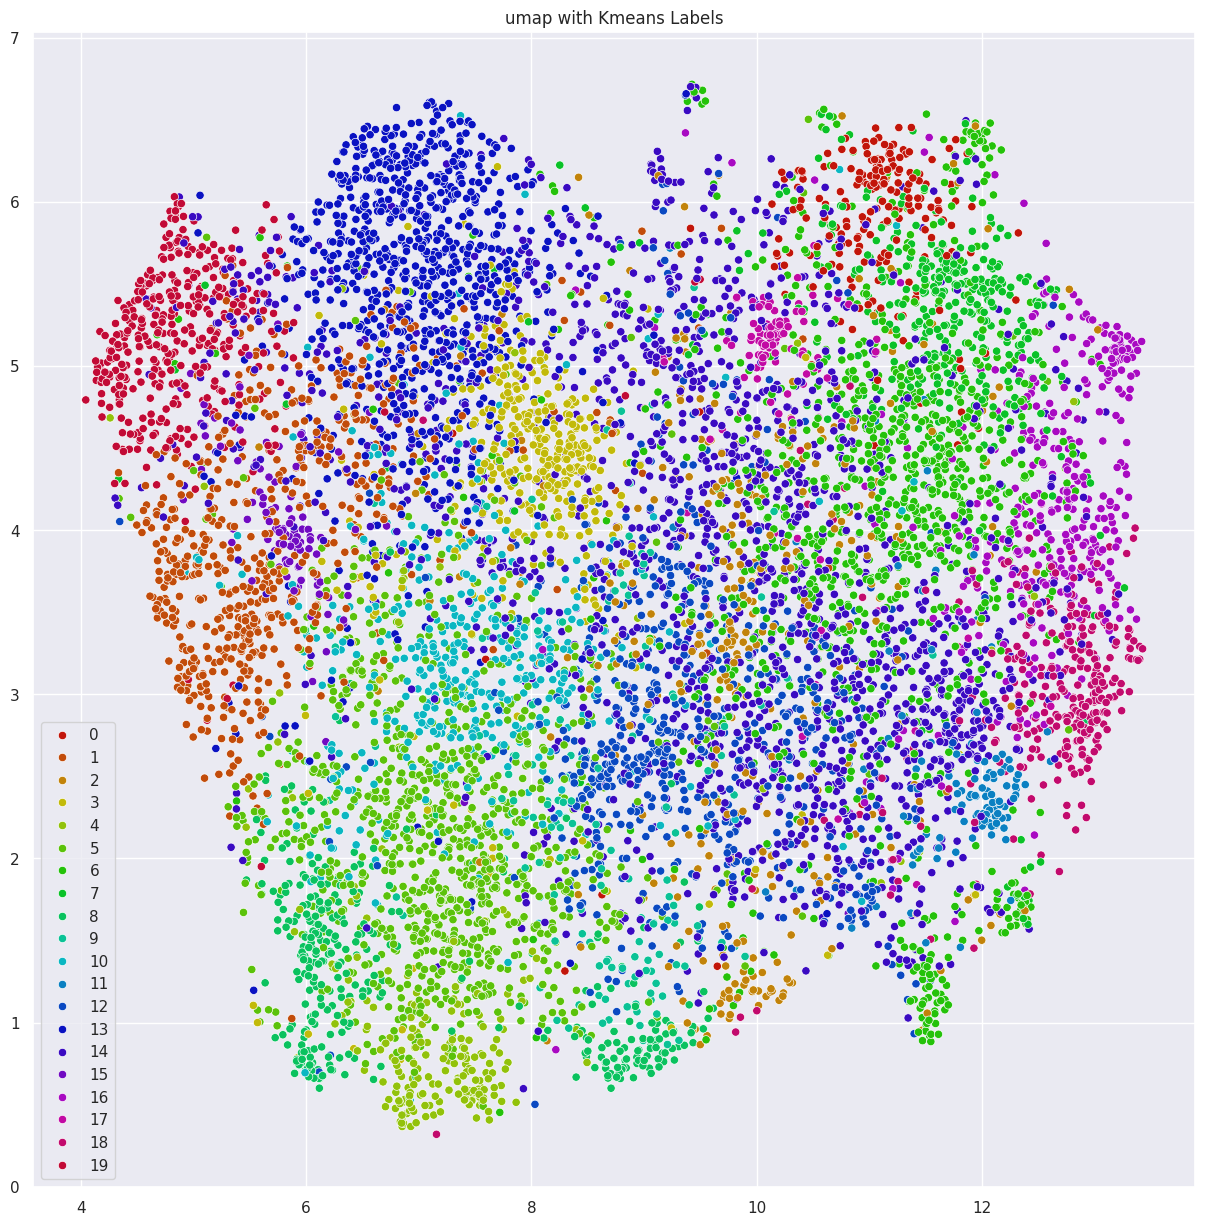

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('umap with Kmeans Labels')
plt.savefig("cluster_umap_kmeans_labels.png")
plt.show()



In [ ]:
import plotly.express as px
fig = px.scatter(df, x=X_embedded[:,0], y=X_embedded[:,1], color=y_pred.astype(str),
                 hover_data=['id', 'authors', 'title',],
                 height= 1000, width=1000,
                title = "t-SNE with Kmeans Labels")
fig.show()